How to use cross-validation for better measures of model performance.

# Introduction

You will face choices about what predictive variables to use, what types of models to use, what arguments to supply to those models, etc. So far, you have made these choices in a data-driven way by measuring model quality with a validation (or holdout) set.

But there are some drawbacks to this approach. To see this, imagine you have a dataset with 5000 rows. You will typically keep about 20% of the data as a validation dataset, or 1000 rows. But this leaves some random chance in determining model scores. That is, a model might do well on one set of 1000 rows, even if it would be inaccurate on a different 1000 rows.

## Gist

In general, larger validation set means less randomness or noise there will be in out measure of model quality, and more reliable it will be.

But we can only get larger validation set by removing rows from our training data, and smaller training data means worse models.

## What is cross-validation?

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

Then, we run one experiment for each fold:

1. In Experiment 1, we use the first fold as a validation (or holdout) set and everything else as training data. This gives us a measure of model quality based on a 20% holdout set.


2. In Experiment 2, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.


3. We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).

## When to use cross-validation?

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use which approach?

1. For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.


2. For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

##### How much is larger dataset or How much is small dataset?

There's no simple threshold for what constitutes a large vs. small dataset. But if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.

In [1]:
import pandas as pd

# Read the data
data = pd.read_csv('datasets/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

Then, we define a pipeline that uses an imputer to fill in missing values and a random forest model to make predictions.

While it's possible to do cross-validation without pipelines, it is quite difficult! Using a pipeline will make the code remarkably straightforward.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(
    steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators=50,random_state=0))
    ]
)

We obtain the cross-validation scores with the cross_val_score() function from scikit-learn. We set the number of folds with the cv parameter.

In [3]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


The scoring parameter chooses a measure of model quality to report: in this case, we chose negative mean absolute error (MAE). The docs for scikit-learn show a [list of options](https://scikit-learn.org/stable/modules/model_evaluation.html).

It is a little surprising that we specify negative MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments.

In [4]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277707.3795913405


Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: note that we no longer need to keep track of separate training and validation sets. So, especially for small datasets, it's a good improvement!

## Applying cross-validation and a method to choose best parameter

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('datasets/melb_data.csv', index_col=False)
test_data = train_data.iloc[10864:,:]
train_data = train_data.iloc[:10864,:]

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['Price'], inplace=True)
y = train_data.Price              
train_data.drop(['Price'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [25]:
13580*0.2

2716.0

In [26]:
13580-2716

10864

In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 10864 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         2716 non-null   object 
 1   Address        2716 non-null   object 
 2   Rooms          2716 non-null   int64  
 3   Type           2716 non-null   object 
 4   Price          2716 non-null   float64
 5   Method         2716 non-null   object 
 6   SellerG        2716 non-null   object 
 7   Date           2716 non-null   object 
 8   Distance       2716 non-null   float64
 9   Postcode       2716 non-null   float64
 10  Bedroom2       2716 non-null   float64
 11  Bathroom       2716 non-null   float64
 12  Car            2654 non-null   float64
 13  Landsize       2716 non-null   float64
 14  BuildingArea   1351 non-null   float64
 15  YearBuilt      1540 non-null   float64
 16  CouncilArea    1349 non-null   object 
 17  Lattitude      2716 non-null   float64
 18  Lon

In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10864 entries, 0 to 10863
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         10864 non-null  object 
 1   Address        10864 non-null  object 
 2   Rooms          10864 non-null  int64  
 3   Type           10864 non-null  object 
 4   Method         10864 non-null  object 
 5   SellerG        10864 non-null  object 
 6   Date           10864 non-null  object 
 7   Distance       10864 non-null  float64
 8   Postcode       10864 non-null  float64
 9   Bedroom2       10864 non-null  float64
 10  Bathroom       10864 non-null  float64
 11  Car            10864 non-null  float64
 12  Landsize       10864 non-null  float64
 13  BuildingArea   5779 non-null   float64
 14  YearBuilt      6665 non-null   float64
 15  CouncilArea    10862 non-null  object 
 16  Lattitude      10864 non-null  float64
 17  Longtitude     10864 non-null  float64
 18  Region

In [29]:
X.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,4019.0
1,2,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
2,3,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
3,3,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,-37.7969,144.9969,4019.0
4,4,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0


For instance, the pipeline below will use SimpleImputer() to replace missing values in the data, before using RandomForestRegressor() to train a random forest model to make predictions. We set the number of trees in the random forest model with the n_estimators parameter, and setting random_state ensures reproducibility.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

You have also learned how to use pipelines in cross-validation. The code below uses the cross_val_score() function to obtain the mean absolute error (MAE), averaged across five different folds. Recall we set the number of folds with the cv parameter.

In [31]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 209652.44360269542


function get_score() that reports the average (over three cross-validation folds) MAE of a machine learning pipeline that uses:

1. the data in X and y to create folds,
2. SimpleImputer() (with all parameters left as default) to replace missing values, and
3. RandomForestRegressor() (with random_state=0) to fit a random forest model.


The n_estimators parameter supplied to get_score() is used when setting the number of trees in the random forest model.

In [32]:
def get_score(n_estimators):
    my_pipeline = Pipeline(
        steps=[
            ('imputer', SimpleImputer()),
            ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
        ]
    )
    # Replace this body with your own code
    score = -1*cross_val_score(my_pipeline ,X, y,
                                cv = 3,
                               scoring='neg_mean_absolute_error')
    return score.mean()

Now, you will use the function that you defined in Step 1 to evaluate the model performance corresponding to eight different values for the number of trees in the random forest: 50, 100, 150, ..., 300, 350, 400.

Store your results in a Python dictionary results, where results[i] is the average MAE returned by get_score(i).

In [33]:
import numpy as np

iterer = np.arange(50, 450, step=50)

results = {x: get_score(x) for x in iterer}
print(results)

{50: 212199.73510690444, 100: 210461.39694324185, 150: 209774.6374935497, 200: 209613.91470599835, 250: 209694.13550690585, 300: 209927.34020534402, 350: 209893.8286538119, 400: 209556.28714783164}


Visualize your results

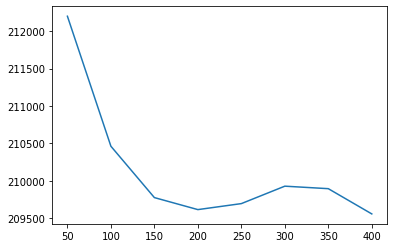

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

which value for n_estimators seems best for the random forest model?

200

We explored one method for choosing appropriate parameters in a machine learning model.

If like to learn more about [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization), you're encouraged to start with grid search, which is a straightforward method for determining the best combination of parameters for a machine learning model. Thankfully, scikit-learn also contains a built-in function GridSearchCV() that can make your grid search code very efficient!